In [35]:
# Cell 1: Environment Setup & Configuration
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import r2_score

# --- Configuration ---
data_path = r"C:\Users\msimc\Documents\Crude vs. gas"
files = {
    "p": 'Permian.csv', "a": 'Appalachia.csv', "h": 'Haynesville.csv',
    "oil": 'WTI.csv', "gas": 'Henry_Price.csv', "mid": 'ngshistory.csv'
}
plt.style.use('seaborn-v0_8-whitegrid')
print("--- Environment Ready ---")

--- Environment Ready ---


C:\Users\msimc\AppData\Local\Temp\ipykernel_8652\3510416744.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mid_df['Date'] = pd.to_datetime(mid_df['Week ending'])


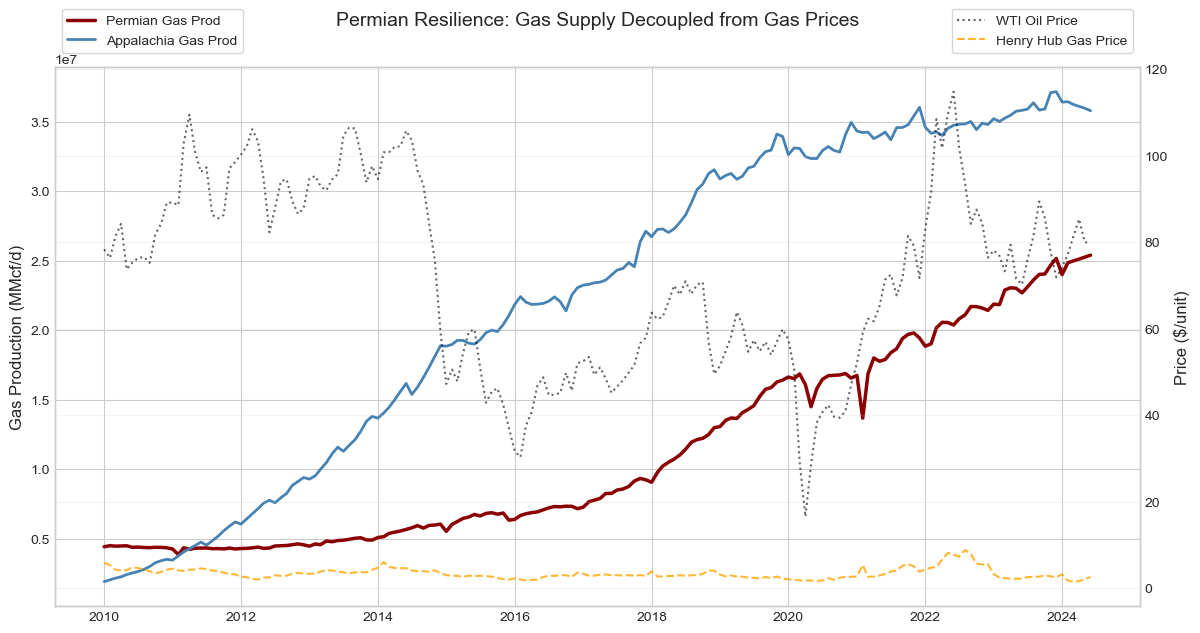

Merge Complete. Rows: 174


In [36]:
# Cell 2: Data Integration & Primary Visualization
def load_and_clean(file_key, name, is_production=True, date_format='%b-%y'):
    df = pd.read_csv(os.path.join(data_path, files[file_key]), thousands=',')
    if is_production:
        df.columns = ['Date', f"{name}_Oil_Prod", f"{name}_Gas_Prod"]
        df['Date'] = pd.to_datetime(df['Date'], format=date_format, errors='coerce')
    else:
        df.columns = ['Date', f"{name}_Price"]
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    return df

# 1. Load and Merge Production/Price Data
master_df = load_and_clean("p", "Permian")
for reg_key, reg_name in [("a", "Appalachia"), ("h", "Haynesville")]:
    master_df = master_df.merge(load_and_clean(reg_key, reg_name), on='Date')

master_df = master_df.merge(load_and_clean("oil", "WTI", False), on='Date') \
                     .merge(load_and_clean("gas", "HH", False), on='Date')

# 2. FIX: Load Storage Data (Required for Cell 5)
mid_df = pd.read_csv(os.path.join(data_path, files["mid"]), skiprows=6, thousands=',')
mid_df['Date'] = pd.to_datetime(mid_df['Week ending'])
mid_df['Permian_Regional_Storage'] = pd.to_numeric(mid_df['Salt'], errors='coerce') + \
                                     pd.to_numeric(mid_df['NonSalt'], errors='coerce')

mid_monthly = mid_df[['Date', 'Permian_Regional_Storage']].set_index('Date').resample('MS').mean().reset_index()
master_df = master_df.merge(mid_monthly, on='Date')

# 3. FIX: Add Missing Calculations (Required for Cells 6 & 8)
master_df['Total_Shale_Gas'] = (
    master_df['Permian_Gas_Prod'] + 
    master_df['Appalachia_Gas_Prod'] + 
    master_df['Haynesville_Gas_Prod']
)

master_df['Permian_Share'] = (master_df['Permian_Gas_Prod'] / master_df['Total_Shale_Gas']) * 100
master_df['Appalachia_Share'] = (master_df['Appalachia_Gas_Prod'] / master_df['Total_Shale_Gas']) * 100
master_df['Haynesville_Share'] = (master_df['Haynesville_Gas_Prod'] / master_df['Total_Shale_Gas']) * 100

# 4. PRIMARY VISUALIZATION: Production vs. Prices
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(master_df['Date'], master_df['Permian_Gas_Prod'], color='darkred', linewidth=2.5, label='Permian Gas Prod')
ax1.plot(master_df['Date'], master_df['Appalachia_Gas_Prod'], color='steelblue', linewidth=2, label='Appalachia Gas Prod')
ax1.set_ylabel('Gas Production (MMcf/d)', fontsize=12)

ax2 = ax1.twinx()
ax2.plot(master_df['Date'], master_df['WTI_Price'], color='black', linestyle=':', alpha=0.6, label='WTI Oil Price')
ax2.plot(master_df['Date'], master_df['HH_Price'], color='orange', linestyle='--', alpha=0.8, label='Henry Hub Gas Price')
ax2.set_ylabel('Price ($/unit)', fontsize=12)

plt.title("Permian Resilience: Gas Supply Decoupled from Gas Prices", fontsize=14, pad=30)
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.12), frameon=True)
ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 1.12), frameon=True)
plt.grid(alpha=0.2)
plt.show()

print(f"Merge Complete. Rows: {len(master_df)}")

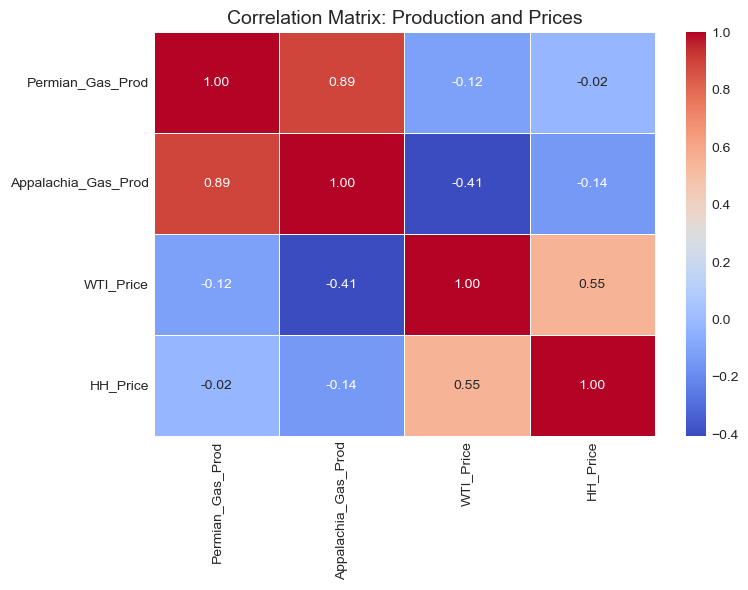

In [37]:
# Cell 3: Correlation Analysis
corr_cols = ['Permian_Gas_Prod', 'Appalachia_Gas_Prod', 'WTI_Price', 'HH_Price']
corr_matrix = master_df[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix: Production and Prices', fontsize=14)
plt.tight_layout()
plt.show()

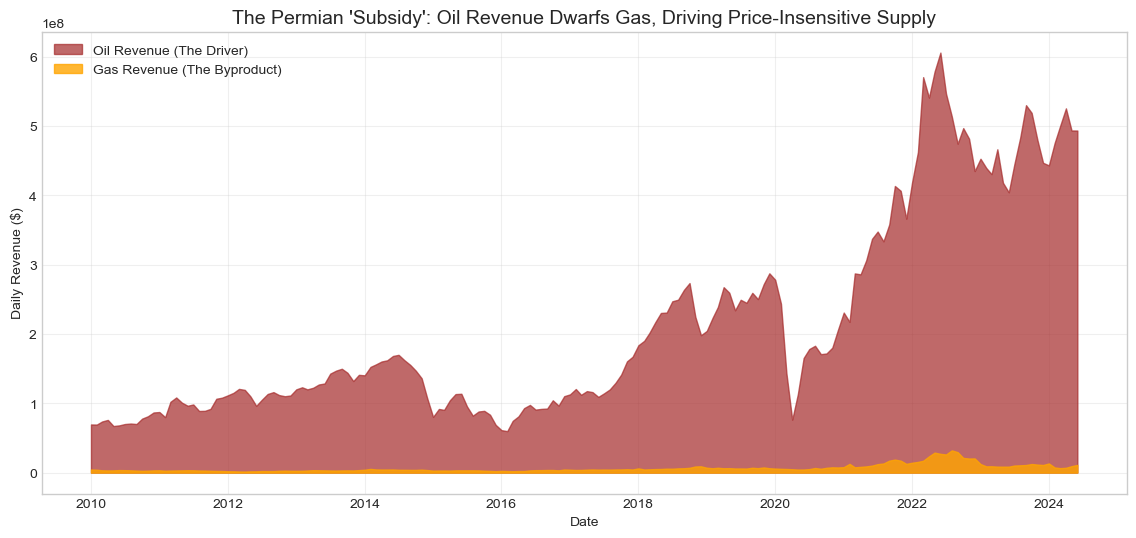

--- PERMIAN ECONOMIC ANALYSIS ---
Average Revenue Contribution from Oil: 97.0%
Average Revenue Contribution from Gas: 3.0%


In [38]:
# Cell 4: Revenue & Economic Analysis
gas_to_boe = 5.8 

master_df['Daily_Oil_Rev'] = master_df['Permian_Oil_Prod'] * master_df['WTI_Price']
master_df['Daily_Gas_Rev'] = (master_df['Permian_Gas_Prod'] / gas_to_boe) * master_df['HH_Price']
master_df['Total_Rev'] = master_df['Daily_Oil_Rev'] + master_df['Daily_Gas_Rev']

master_df['Oil_Rev_Pct'] = (master_df['Daily_Oil_Rev'] / master_df['Total_Rev']) * 100
avg_oil_rev = master_df['Oil_Rev_Pct'].mean()

# --- THE PERMIAN SUBSIDY GRAPH ---
plt.figure(figsize=(14, 6))
plt.fill_between(master_df['Date'], master_df['Daily_Oil_Rev'], color='brown', alpha=0.7, label='Oil Revenue (The Driver)')
plt.fill_between(master_df['Date'], master_df['Daily_Gas_Rev'], color='orange', alpha=0.8, label='Gas Revenue (The Byproduct)')

plt.title("The Permian 'Subsidy': Oil Revenue Dwarfs Gas, Driving Price-Insensitive Supply", fontsize=14)
plt.ylabel('Daily Revenue ($)')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()

print("--- PERMIAN ECONOMIC ANALYSIS ---")
print(f"Average Revenue Contribution from Oil: {avg_oil_rev:.1f}%")
print(f"Average Revenue Contribution from Gas: {100 - avg_oil_rev:.1f}%")

In [ ]:
# Cell 5: Midstream Bottleneck Analysis
master_df['Bottleneck_Proxy'] = master_df['Permian_Gas_Prod'] / master_df['Permian_Regional_Storage']
bottleneck_corr = master_df['WTI_Price'].corr(master_df['Bottleneck_Proxy'])

print(f"--- Midstream 'Uncorking' Analysis ---")
print(f"Correlation (WTI Price vs Bottleneck Proxy): {bottleneck_corr:.2f}")

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(master_df['Date'], master_df['WTI_Price'], color='black', label='WTI Oil Price')
ax1.set_ylabel('Oil Price ($/bbl)')
ax2 = ax1.twinx()
ax2.plot(master_df['Date'], master_df['Bottleneck_Proxy'], color='red', linestyle='--', label='Bottleneck Proxy')
ax2.set_ylabel('Bottleneck Proxy (Prod/Storage)')

plt.title('The Irony of the Permian: Oil Prices vs. Gas Pipeline Congestion')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [ ]:
# Cell 6: Feature Engineering for ML
for col in ['WTI_Price', 'HH_Price', 'Permian_Gas_Prod', 'Total_Shale_Gas']:
    for lag in [1, 3, 6]:
        master_df[f'{col}_Lag{lag}'] = master_df[col].shift(lag)
    master_df[f'{col}_Roll3'] = master_df[col].rolling(window=3).mean()
    master_df[f'{col}_Roll6'] = master_df[col].rolling(window=6).mean()

master_df['Month'] = master_df['Date'].dt.month
ml_df = master_df.dropna().copy()

print(f"Feature Engineering Complete. ML-ready rows: {len(ml_df)}")

In [ ]:
# Cell 7: XGBoost Model Training
train = ml_df[ml_df['Date'] < '2023-01-01']
test = ml_df[ml_df['Date'] >= '2023-01-01']

features = ['WTI_Price', 'Permian_Gas_Prod_Lag1', 'Permian_Gas_Prod_Lag3', 
            'Total_Shale_Gas_Lag1', 'WTI_Price_Roll3', 'Month']
target = 'HH_Price'

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
xgb_model.fit(train[features], train[target])

# Shock calculation for summary
base_pred = xgb_model.predict(test[features]).mean()
shock_features = test[features].copy()
shock_features['Permian_Gas_Prod_Lag1'] *= 0.8
shock_pred = xgb_model.predict(shock_features).mean()
shock_pct = ((shock_pred - base_pred) / base_pred) * 100

print(f"Training R² Score: {r2_score(train[target], xgb_model.predict(train[features])):.2f}")
print(f"Test R² Score: {r2_score(test[target], xgb_model.predict(test[features])):.2f}")

In [ ]:
# Cell 8: Market Share Visualization & Summary
plt.figure(figsize=(12, 6))
plt.stackplot(master_df['Date'], 
              master_df['Permian_Share'], 
              master_df['Appalachia_Share'], 
              master_df['Haynesville_Share'],
              labels=['Permian', 'Appalachia', 'Haynesville'],
              colors=['#8b0000', '#4682b4', '#2e8b57'], alpha=0.8)

plt.title('Market Share of Major US Shale Gas Production', fontsize=14)
plt.ylabel('Market Share (%)')
plt.legend(loc='upper left')
plt.margins(0,0)
plt.show()

output_file = os.path.join(data_path, "OIG_Complete_Analysis.csv")
master_df.to_csv(output_file, index=False)

current_share = master_df['Permian_Share'].iloc[-1]
print(f"--- Analysis Complete ---")
print(f"Full dataset exported to: {output_file}")
print(f"\n--- KEY FINDINGS SUMMARY ---")
print(f"1. Permian accounts for {current_share:.1f}% of major shale gas production")
print(f"2. Oil provides {avg_oil_rev:.1f}% of Permian revenue (gas is a byproduct)")
print(f"3. Removing Permian supply would increase gas prices by {abs(shock_pct):.1f}% (ML model)")
print(f"4. WTI-Bottleneck correlation of {bottleneck_corr:.2f} supports 'uncorking' thesis")